# Module 4 Final Project Submission
#### Time Series Analysis

* Student name: Dean Stallons
* Student pace: Part-Time
* Scheduled project review date/time: Friday January 24, 2020, 3:00pm CST
* Instructor name: Abhineet Kulkarni

## Introduction:

In this project, ACME Real Estate Co. has tasked me with reccomendations for which are the top 5 zip codes to purchase and develop into retirement communities. They want to take a data driven approach to focus on proprty that will be desireable for rent, but also will appreciate over time. The dataset that I will be using as primary will be Zillow's housing data from mid-1996 to mid-2018.

## Methodology

My first step will be using some extracted data analysis to narrow down the zip-code pool I am looking into. When considering which states to choose, I did some research and wanted to singularily look at the top 10 states where retirement was responsible for inbound moves. I found this very detail from an article on investopedia: https://www.investopedia.com/articles/retirement/020117/most-popular-states-retire-us.asp

* New Mexico (43%)
* Florida (39%)
* Arizona (37%)
* South Carolina (37%)
* Idaho (34%)
* Maine (33%)
* Vermont (31%)
* Nevada (29%)
* Wyoming (27%)
* Montana (26%)

Next I chose to consider median home prices as a descriptor of returns on investment, risk of volitility (using the coefficient of variance), and target purchase power relative to yearly sales. To address the last item in this list I will only take regions/zipcodes who have median yearly values in the middle 80% of the total pool. This is to avoid cherry picking exceedingly expensive or affordable neighborhoods. 

After narrowing my regions to a selection of 5, I will be performing Time Series analysis. I will utilize the SARIMA model as home sales are very likely to be seasonal in nature, follow trends, and the monthly cycles fit nicely into that model. In addition to that model, the method I will be using is the Box-Jenkins method.

1.) Identification: Using the pool of data, selecting a sub-class of that data to best summarize the model.

2.) Estimation: Use the data from my subset to train and test the parameters of the model.

3.) Checking: Evaluate the fit of the model and forecasts against the available parameters.

https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/

## Step 1: Import Libraries, Functions, and Dataset

In [80]:
#Install PMDARIMA to assist with forecasting and use of SARIMA model.
pip install pmdarima

     |████████████████████████████████| 604kB 2.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [81]:
#Import the necessary libraries for EDA, visualization and time series modelling.
#Data visualization and manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
#Set warning to be ignored
import warnings
warnings.simplefilter('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline
#Time series analysis tools.
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [422]:
#Helper Functions
#Obtain dates from the data. Source: Flatiron School
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

#Convert the data into long format. Source: Flatiron School
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

#Function for making ACF and PACF plots standard visualization.
def acf_pacf(df,alags=48,plags=48):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,7))
    #Make ACF plot
    plot_acf(df,lags=alags, zero=False,ax=ax1)
    #Make PACF plot
    plot_pacf(df,lags=plags, ax=ax2)
    plt.show()


def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Using the rolling mean to find seasonality.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_34698diff - TS_34698diff.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();
    
def train_test(df):
    #Set trainning data before April 2015
    train = df[:'2015-04']
    #Set test data after April 2015
    test = df['2015-05':]
    return train, test

#Quick function to fit resulst so SARIMA model
def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

#Functions for test and train sets of the residual mean squared error. Source: Fernando Aguilar
def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

#Forecast model for predicting outputs at different years in the future based on test and train sets. Source: Fernando Aguilar
def forecast_model(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [244]:
import numpy as np
import pandas as pd
zillow_df = pd.read_csv('zillow_data.csv')
zillow_df.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [245]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


#### Data Summary

All of the data is in a dataframe format now. There are 14,722 unique zip codes of data. I can also see that it is in wide format which will need to be translated into a long format in order to sort the date on the X axis for time series analysis.

# Step 2: ZIP Code Selection, EDA, and Visualization

The investment company looking to invest in real estate is specifically interested in and has experience in retirement communities. Therefore, they are looking for zipcodes that are specifically in highly desirable retirement states; specifically they have New Mexico, South Carolina, Idaho, Maine, Vermont, Nevada, Wyoming, Montana, Arizona, and Florida in scope. 

In [315]:
#Narrow the dataframe to only include zip codes from Florida
Sun_df= zillow_df[zillow_df['State'].isin(['NM','AZ','SC','ID','ME','VT','FL','NV','WY','MT','AZ'])].drop(
                                                      ['RegionID','City',
                                                       'State','Metro','CountyName',],axis=1)
print(f'Amount of zipcodes: {len(Sun_df)}')

Amount of zipcodes: 1698


In [316]:
Sun_df.head()

,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,32162,12,101000.0,100700.0,100400.0,100100.0,99800.0,99500.0,99200.0,98900.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
56,85032,57,95400.0,95800.0,96200.0,96700.0,97200.0,97600.0,98100.0,98500.0,...,255000,256300,257800,259500,260700,261900,263100,264100,265400,266400
60,33160,61,337300.0,337900.0,338300.0,338400.0,338400.0,338200.0,338000.0,338000.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
82,33025,83,111600.0,111700.0,111800.0,111900.0,112000.0,112100.0,112200.0,112300.0,...,283500,286100,287800,288800,289700,291000,292500,294200,296400,298200
83,33411,84,126800.0,126800.0,126800.0,126800.0,126700.0,126700.0,126800.0,126800.0,...,297400,299300,301400,303300,304900,307100,309800,311700,312600,313100


We now have 1,698 zip codes to choose from in the retirement states. This is a reduction from the original amount of over 14,000 regions. The final reduction step I will take before performing any EDA is to only select zip codes that are in the top 25% of the size rank spectrum in comparison with the rankings of the other regions within these states. I am doing this because ACME Real Estate will not want to invest in property unless it is in more urbanized locations. Retirees will want to be by resources, hospitals, airports, etc.

In [317]:
#Get zipcodes with a size rank in the top 20% (highly urbanized zipcodes).
print(Sun_df.SizeRank.describe(),'\n')
#Calculate the 20% cutoff value.
sr_25 = Sun_df.SizeRank.quantile(q=0.25)
print(f'Size Rank 25% cutoff value: {sr_25}')
#Get final data frame with selected zipcodes. Keep values and zipcodes only.
Sun_df= Sun_df[Sun_df['SizeRank']<sr_25].drop(['SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(Sun_df)}')

count     1698.000000
mean      6019.526502
std       4001.256237
min         12.000000
25%       2610.500000
50%       5419.500000
75%       9013.250000
max      14723.000000
Name: SizeRank, dtype: float64 

Size Rank 25% cutoff value: 2610.5
Amount of zipcodes: 425


#### Pre-Selection of Zip Codes after State Filter

I started with a 1 year parameter to make sure I am capturing the most applicable prices with a nod to some recency bias.

Median house prices: I will then take all of the zipcodes who fall between 20% above and 20% below the median monthly house values. This is to protect against some risk appetite and to also make sure we are getting predictable, expected returns.

In [318]:
Sun_df['yr_avg']=Sun_df.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 20% above the median and 20% below.
print(Sun_df['yr_avg'].describe(),'\n')
#Calculate the 70% cutoff value (20% above median).
p_70 = Sun_df['yr_avg'].quantile(q=0.70)
print(f'Average Value 60% cutoff value: {round(p_70,2)}')
#Calculate the 30% cutoff value (20% below median).
p_30 = Sun_df['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(p_30,2)}')
#Get data frame with selected zipcodes.
Sun_pre= Sun_df[(Sun_df['yr_avg']<p_70) & (Sun_df['yr_avg']>p_30)]
print(f'Amount of zipcodes: {len(Sun_pre)}')

count    4.250000e+02
mean     2.627603e+05
std      1.925917e+05
min      7.801667e+04
25%      1.810167e+05
50%      2.292583e+05
75%      2.901000e+05
max      2.923933e+06
Name: yr_avg, dtype: float64 

Average Value 60% cutoff value: 279395.0
Average Value 30% cutoff value: 188688.33
Amount of zipcodes: 169


So now we are down to 678 zipcodes of which have predictable, expected results.

The next step I want to take in my selection of zip codes is to calculate a return on investment based on historical returns for each zip code. I will simply divide the current median price from the oldest reported to get the greatest ROI over the sample's timeframe. The goal is to capture markets that have a more significant rise. I will also calculate the standard deviation of monthly values, mean, and coefficient of variance for each region.

In [319]:
#Calculate historical return on investment
Sun_pre['ROI']= (Sun_pre['2018-04']/Sun_pre['1996-04'])-1
#Calculate standard deviation of monthly values
Sun_pre['std']=Sun_pre.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
#Calculate historical mean value
Sun_pre['mean']=Sun_pre.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
#Calculate coefficient of variance
Sun_pre['CV']=Sun_pre['std']/Sun_pre['mean']
#Show calculated values
Sun_pre[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
11,32162,53805.394161,183692.830189,1.493069,0.292910
56,85032,54515.218544,175300.377358,1.792453,0.310982
108,85225,49076.467023,172230.188679,1.566206,0.284947
110,87111,41735.065710,203678.490566,0.695347,0.204907
114,87114,25925.959377,179203.018868,0.565468,0.144674


Now I will set a limit on coefficient of variance to an appropriate risk tollerance, fileter all the regions below that, and select the top 5 zip codes according to ROI after. The tolerance I have chosen is anything in the bottow 3/4 of returns to avoid the top 25% riskiest regions.

In [320]:
#Descriptive statistics of coefficients of variance.
print(Sun_pre.CV.describe())
#Define upper limit of CV according to risk profile.
upper_cv = Sun_pre.CV.quantile(.75)
print(f'\nCV upper limit: {upper_cv}')
#Get the 10 zipcodes with highest ROIs within the firms risk profile.
Sun_top10 = Sun_pre[Sun_pre['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
Sun_top10[['RegionName','ROI','CV']]

count    169.000000
mean       0.294695
std        0.070084
min        0.126012
25%        0.256119
50%        0.297169
75%        0.337235
max        0.444346
Name: CV, dtype: float64

CV upper limit: 0.3372352624666204

 Best 5 Zipcodes:


,RegionName,ROI,CV
122,85281,2.189655,0.321302
2105,33710,2.154993,0.324490
1911,33702,2.066291,0.317932
1877,29461,2.061224,0.249053
668,34698,2.054779,0.302079


In [321]:
#Get Location Names
Sun_top10_zipcodes = list(Sun_top10.RegionName.values)
for i in Sun_top10_zipcodes:
    city = zillow_df[zillow_df['RegionName']==i].City.values[0]
    state = zillow_df[zillow_df['RegionName']==i].State.values[0]
    print(f'Zipcode : {i} \nLocation: {city}, {state}\n')

Zipcode : 85281 
Location: Tempe, AZ

Zipcode : 33710 
Location: Saint Petersburg, FL

Zipcode : 33702 
Location: Saint Petersburg, FL

Zipcode : 29461 
Location: Moncks Corner, SC

Zipcode : 34698 
Location: Dunedin, FL



# Step 3: Time Series Analysis

#### Now I will have all of the date columns translated to datetime objects I will drop the final columns and melt the dates and values. Finally I will index the dates

In [323]:
TS_Sun10 = Sun_top10.drop(['yr_avg','std','mean','ROI','CV'],axis=1)
TS_Sun10 = melt_data(TS_Sun10).set_index('time')
print('Time series data for the 5 zipcodes:\n',TS_Sun10.head(10))
#Create individualized time series for each zipcode.
#List containing the 10 different time series.
dfs_ts = []
for zipcode in TS_Sun10.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = TS_Sun10[TS_Sun10['RegionName']==zipcode].asfreq('MS')
    dfs_ts.append(df)
print('\nZipcode 85281 time series:')
dfs_ts[0].head(14)

Time series data for the 5 zipcodes:
             RegionName    value
time                           
1996-04-01       85281  81200.0
1996-04-01       33710  67100.0
1996-04-01       33702  70900.0
1996-04-01       29461  68600.0
1996-04-01       34698  85800.0
1996-05-01       85281  81500.0
1996-05-01       33710  67100.0
1996-05-01       33702  70800.0
1996-05-01       29461  68600.0
1996-05-01       34698  85800.0

Zipcode 85281 time series:


,RegionName,value
time,,
1996-04-01,85281,81200.0
1996-05-01,85281,81500.0
1996-06-01,85281,81900.0
1996-07-01,85281,82200.0
1996-08-01,85281,82500.0
1996-09-01,85281,82800.0
1996-10-01,85281,83200.0
1996-11-01,85281,83600.0
1996-12-01,85281,84100.0


#### Descriptive Statistics

My next step will be to take a look at the descriptive statistics for the 10 zip codes in my scope.

In [324]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].RegionName[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 85281:
count       265.000000
mean     163401.132075
std       52501.033527
min       81200.000000
25%      122700.000000
50%      155000.000000
75%      206900.000000
max      259000.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 33710:
count       265.000000
mean     127343.396226
std       41321.669188
min       67000.000000
25%       95700.000000
50%      122200.000000
75%      157100.000000
max      211700.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 33702:
count       265.000000
mean     127033.584906
std       40388.068815
min       70800.000000
25%       96200.000000
50%      116800.000000
75%      156200.000000
max      217400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 29461:
count       265.000000
mean     145173.207547
std       36155.846366
min       68000.000000
25%      115700.000000
50%      157300.000000
75%      168500.000000
max     

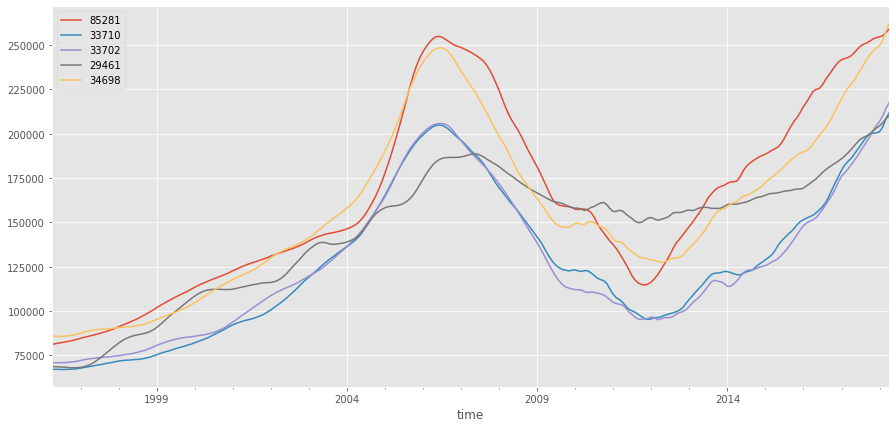

In [325]:
#Visual of all 5 zip codes in time series graph
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0],figsize=(15,7))
    plt.legend()

This graph has a nice visual of really something we would all expect; the home prices of each region went up over time. We can also clearly see the housing bubble of 2005/6, and the following crash in the middle of this graph. However, instead of price change over time, I believe it would be better to compare monthly returns of these values.

In [326]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1

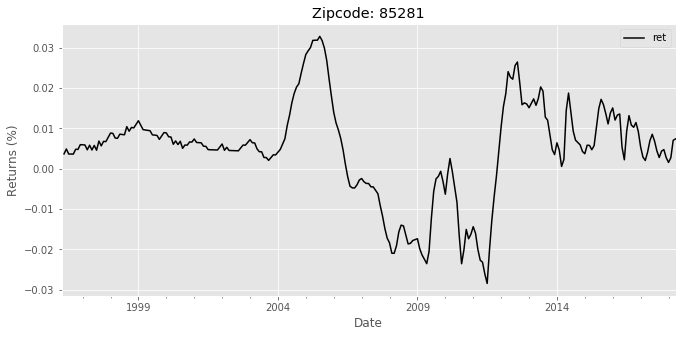

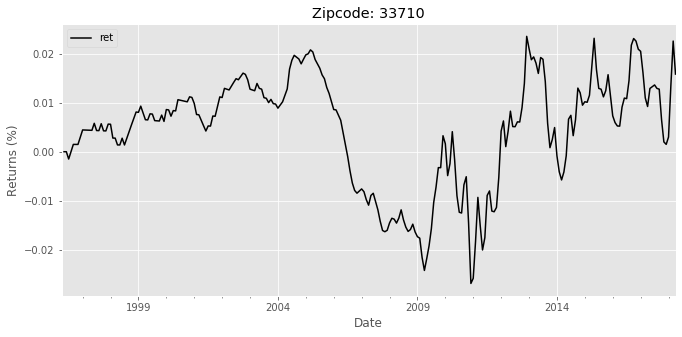

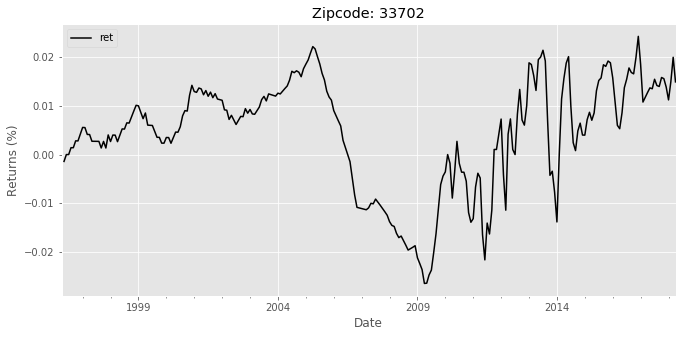

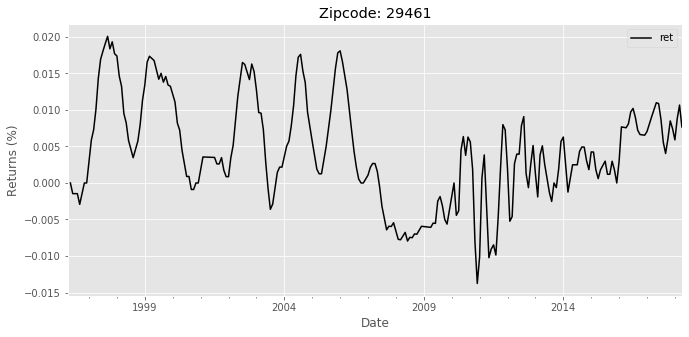

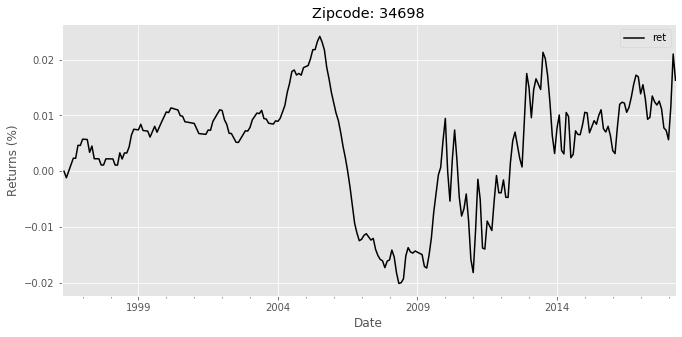

In [327]:
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11,5), color = 'black')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

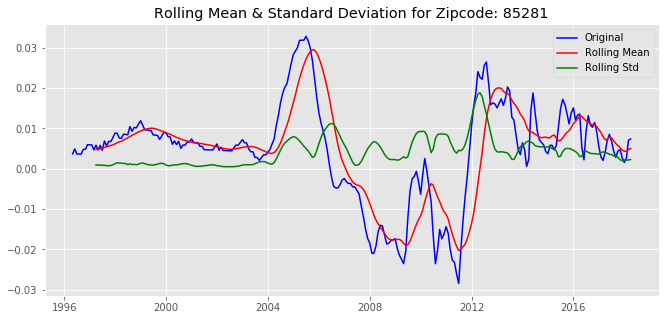

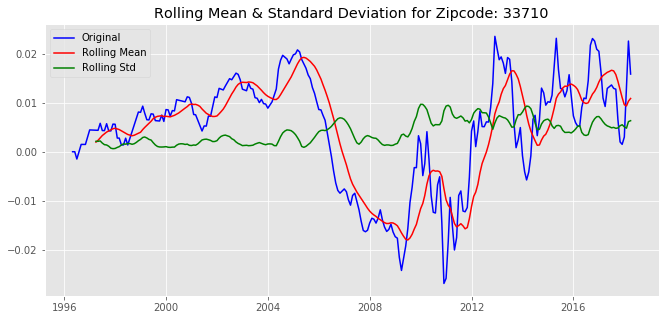

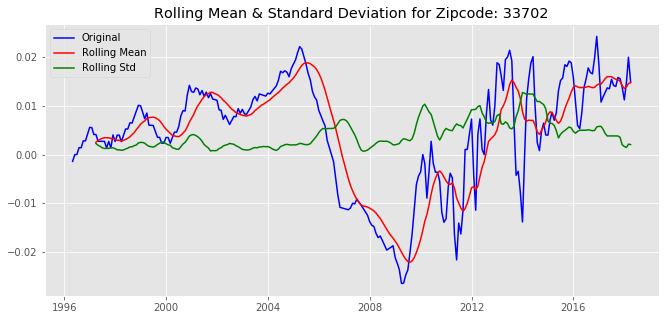

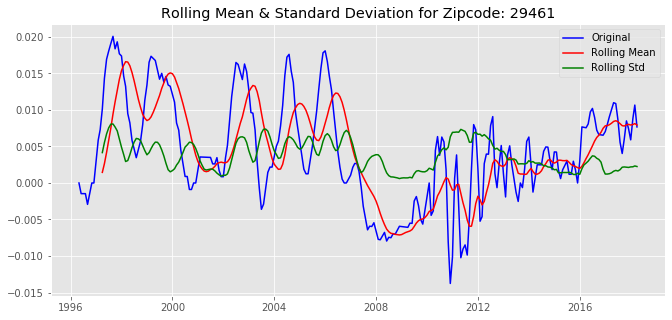

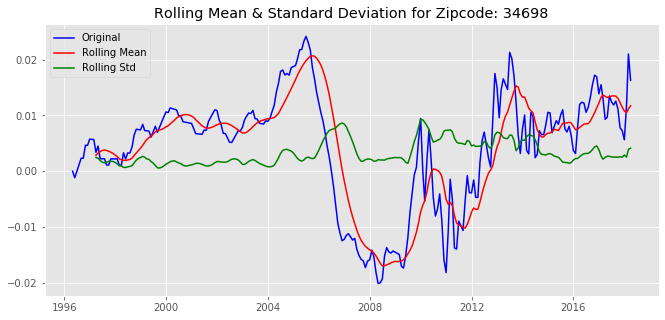

In [328]:
#Plot each of the zipcodes' returns with their respective rolling mean and rolling standard deviation.
#Vizually test for stationarity.
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

Just by taking a glance at the trends, the data appears stationary. To validate this, I will run an Augmented Dickey-Fuller test to confirm or deny the null hypothesis of this.

In [329]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 85281
p-value: 0.023323584977293248
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 33710
p-value: 0.34346686049971886
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 33702
p-value: 0.27141578391754745
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 29461
p-value: 0.35487077145143764
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 34698
p-value: 0.16051563435373828
Fail to reject the null hypothesis. Data is not stationary.



Only the 1st region reports as stationary. I will test the other 4 regions against ADFuller, taking their first difference and drop NaN values that were created. This should hopefully confirm, after taking the difference of their stationarity.

In [330]:
for i in [1,2,3,4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 33710
p-value: 1.2762667678287358e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 33702
p-value: 0.00016567400026252637
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 29461
p-value: 1.60489096321814e-10
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 34698
p-value: 4.61727110874037e-05
Reject the null hypothesis. Data is stationary.



As expected, now all of the data sets are stationary.

**Now all of the data reports as stationary.**

I will take 0 for the "I" with the first region...all of the other regions I will use 1 for "I"

In [331]:
#Create individual time series for each of the zipcodes.
TS_85281 = dfs_ts[0].ret.dropna()#Zipcode 85281 monthly returns time series

TS_33710 = dfs_ts[1].ret.dropna()#Zipcode 33710 monthly returns time series
TS_33710diff = dfs_ts[1].ret.diff().dropna()#Zipcode 33710 monthly returns differenced time series

TS_33702 = dfs_ts[2].ret.dropna()#Zipcode 33702 monthly returns time series
TS_33702diff = dfs_ts[2].ret.diff().dropna()#Zipcode 33702 monthly returns differenced time series

TS_29461 = dfs_ts[3].ret.dropna()#Zipcode 29461 monthly returns time series
TS_29461diff = dfs_ts[3].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

TS_34698 = dfs_ts[4].ret.dropna()#Zipcode 34698 monthly returns time series
TS_34698diff = dfs_ts[4].ret.diff().dropna()#Zipcode 34698 monthly returns differenced time series

### 85281 Tempe, AZ

I will start with 1 for the "I" parameter as the data was stationary after taking the first difference and run acf / pacf to find the "p" and "q" parameters to use in the SARIMA model.

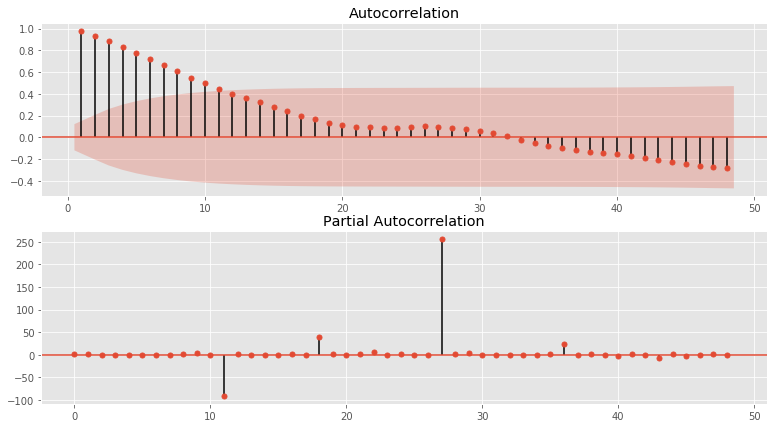

In [333]:
acf_pacf(TS_85281)

I can tell from these plots that because they trail off, the Q(MA) will most likely 0 or 1 and the P(AR) will be around the same. Now I will check on seasonality.

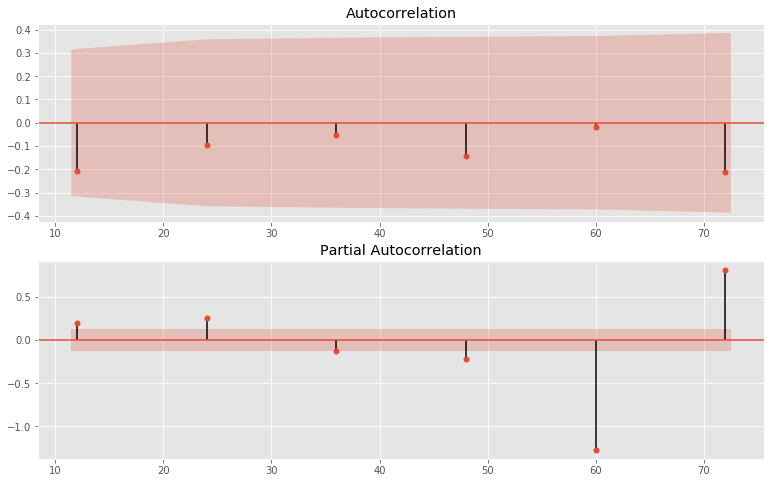

In [334]:
seasonal_plots(TS_85281, N=13)

I do not see any significant statistical seasonality as might be expected around each period of 12 months. This may lead to not much of a return over time. Now I will test ARIMA to get parameters for the SARIMA model.

In [384]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_85281,information_criterion='aic',d=0,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-2473.732, BIC=-2452.276, Fit time=0.163 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-1579.893, BIC=-1572.741, Fit time=0.043 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-2383.019, BIC=-2372.291, Fit time=0.137 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-1903.276, BIC=-1892.548, Fit time=0.189 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-1547.770, BIC=-1544.194, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-2477.752, BIC=-2459.872, Fit time=0.178 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-2162.011, BIC=-2147.707, Fit time=0.152 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-2471.487, BIC=-2457.184, Fit time=0.131 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-2477.887, BIC=-2456.431, Fit time=0.189 seconds
Fit ARIMA: order=(0

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1087.539
Date:                Fri, 24 Jan 2020   AIC                          -2161.078
Time:                        09:24:08   BIC                          -2137.072
Sample:                    05-01-1996   HQIC                         -2151.392
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9355      0.026     36.043      0.000       0.885       0.986
ma.L1          0.7797      0.065     12.016      0.000       0.653       0.907
ma.L2          0.2660      0.079      3.357      0.0

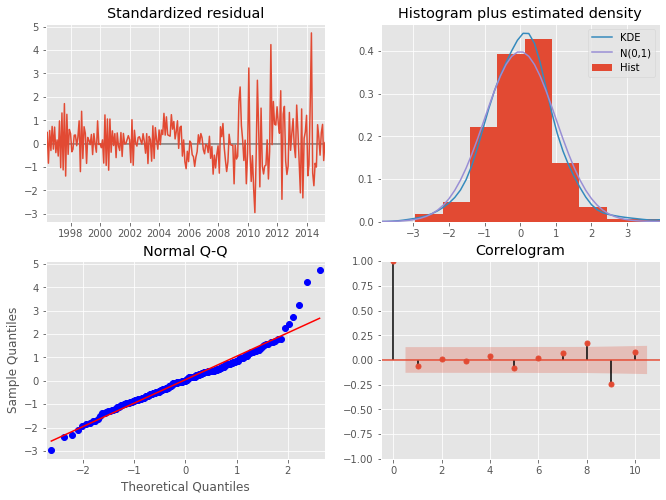

In [385]:
#Fit the SARIMA model and get results.
pdq = (1,0,5)
pdqs = (0,0,0,1)
train, test, results = model_fit(TS_85281,pdq=pdq,pdqs=pdqs)

The seasonal ARIMA model seems to be capturing very well the predictive model vs the train data. I can tell by looking at the Q-Q plot, as well as the histogram that the normalized data looks good and the vast majority of the outliers are covered nicely. Additionally, the residuals graph looks like it isn't having any effect on the trained data. Probability is at 4% which gives me confidence that the large Ljung-Box score is an outlier.

SARIMA model RMSE on train data: 0.00284


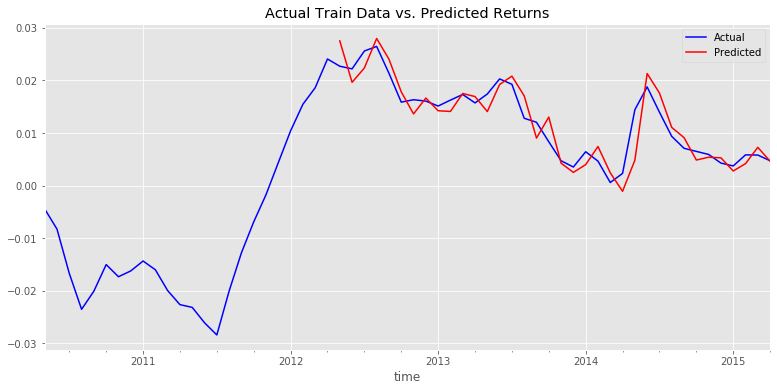

In [386]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00246


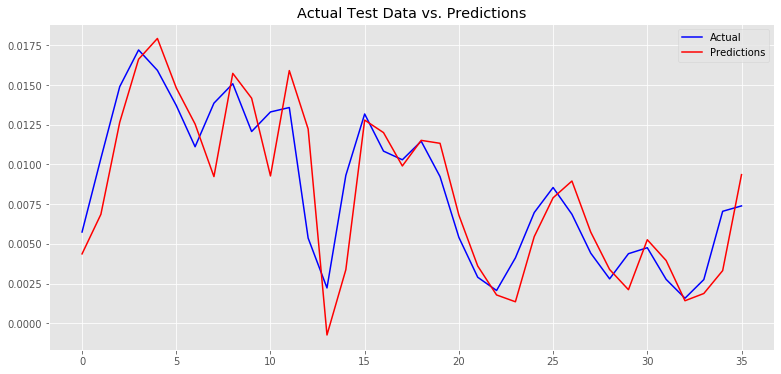

In [387]:
test_RMSE(TS_85281,pdq=pdq,pdqs=pdqs, display=True)

It seems that the test and train data are tracking in a highly predictive fashion. This gives me confidence to move onto the forecast portion of predicting returns for the next 1, 3, 5, and 10 years.

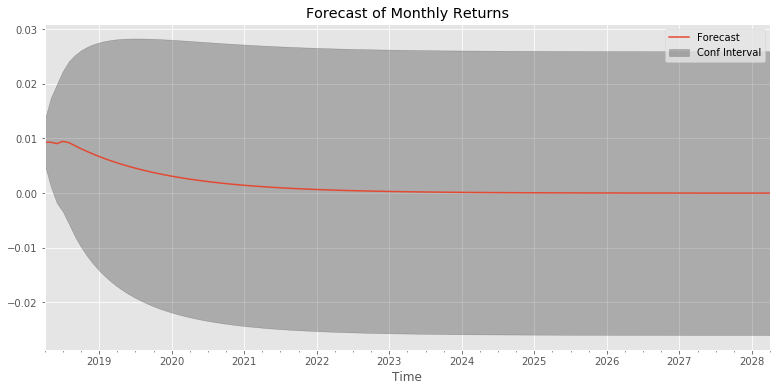

Total expected return in 1 year: 10.13%
Total expected return in 3 years: 18.1%
Total expected return in 5 year: 19.89%
Total expected return in 10 years: 20.37%


In [388]:
forecast_85281 = forecast_model(TS_85281,pdq=pdq,pdqs=pdqs,zc=85281)

### 33710 Saint Petersburg, FL

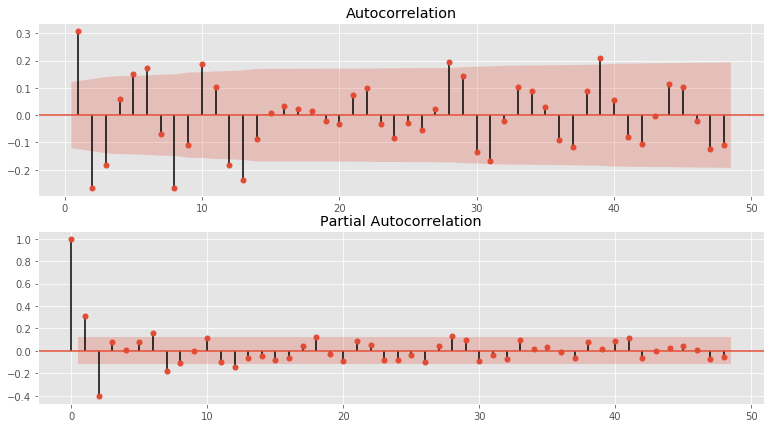

In [341]:
acf_pacf(TS_33710diff)

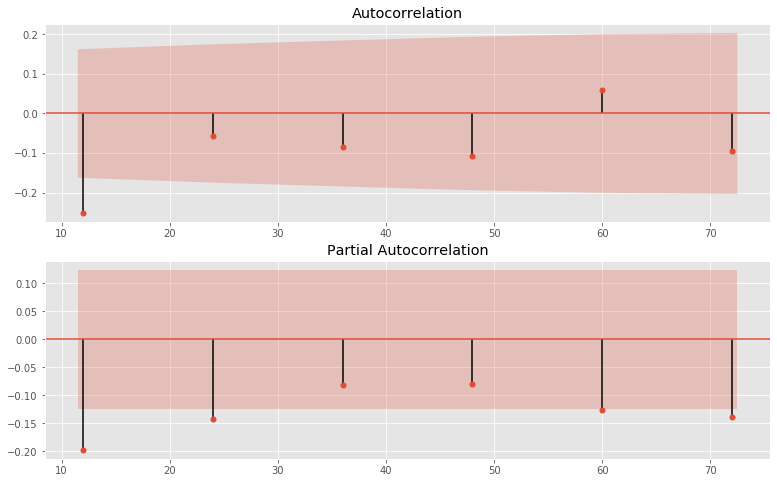

In [342]:
seasonal_plots(TS_33710diff, N=13)

In [343]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_33710diff,information_criterion='aic',m=12,d=1,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=-2348.911, BIC=-2320.364, Fit time=0.387 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2205.265, BIC=-2198.128, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-2211.421, BIC=-2197.148, Fit time=0.225 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-2222.037, BIC=-2207.764, Fit time=0.201 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2207.250, BIC=-2203.682, Fit time=0.029 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=-2353.114, BIC=-2328.136, Fit time=0.325 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=-2346.270, BIC=-2324.860, Fit time=0.166 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 12); AIC=-2352.211, BIC=-2323.664, Fit time=0.743 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=-2353.014, BIC=-2328.035, Fit time=0.712 seconds
Fit ARIMA:

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

                                 Statespace Model Results                                 
Dep. Variable:                                ret   No. Observations:                  227
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 12)   Log Likelihood                1036.253
Date:                            Thu, 23 Jan 2020   AIC                          -2060.506
Time:                                    12:54:23   BIC                          -2039.982
Sample:                                06-01-1996   HQIC                         -2052.223
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4588      0.091      5.029      0.000       0.280       0.638
ar.L2         -0.5127      0.061   

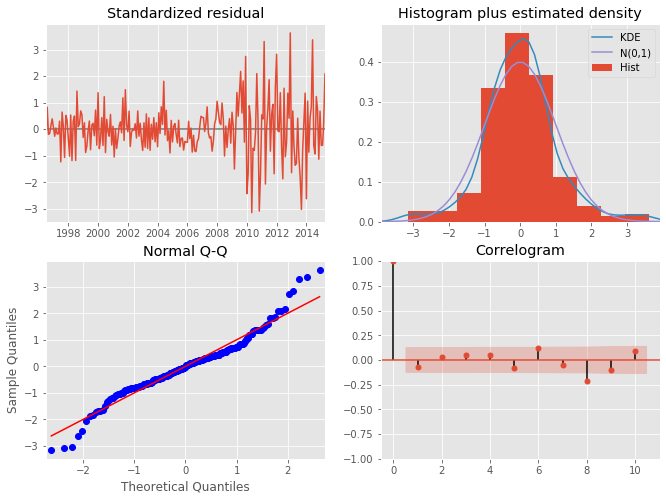

In [344]:
#Fit the SARIMA model and get results.
pdq = (2,1,2)
pdqs = (0,0,1,12)
train, test, results = model_fit(TS_33710diff,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00358


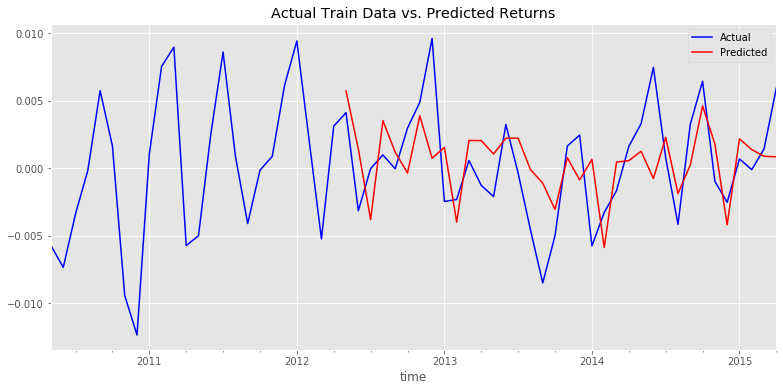

In [345]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00352


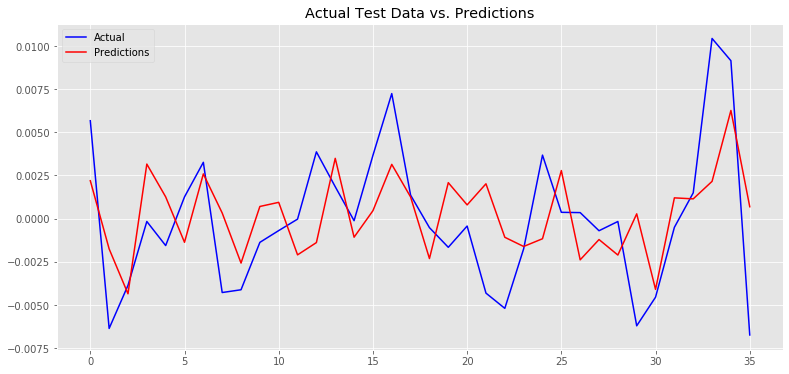

In [346]:
test_RMSE(TS_33710diff,pdq=pdq,pdqs=pdqs, display=True)

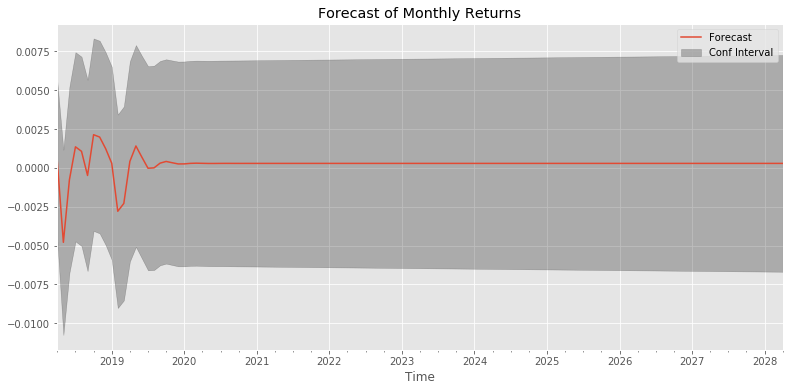

Total expected return in 1 year: -0.27%
Total expected return in 3 years: 0.53%
Total expected return in 5 year: 1.22%
Total expected return in 10 years: 3.0%


In [347]:
forecast_33710 = forecast_model(TS_33710diff,pdq=pdq,pdqs=pdqs,zc=33710)

### 33702 Saint Petersburg, FL

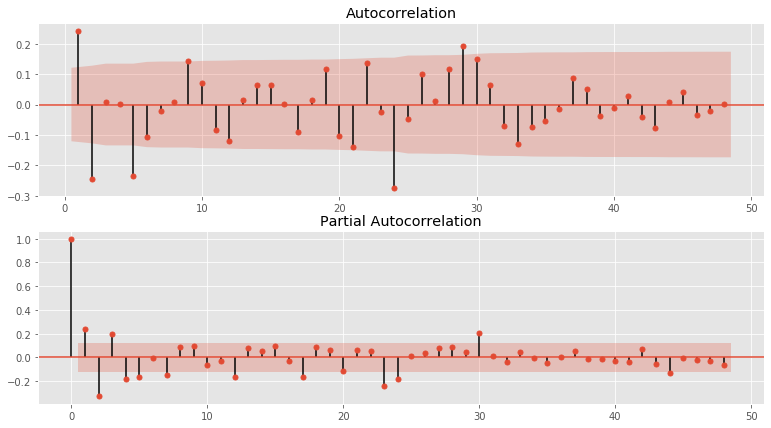

In [348]:
acf_pacf(TS_33702diff)

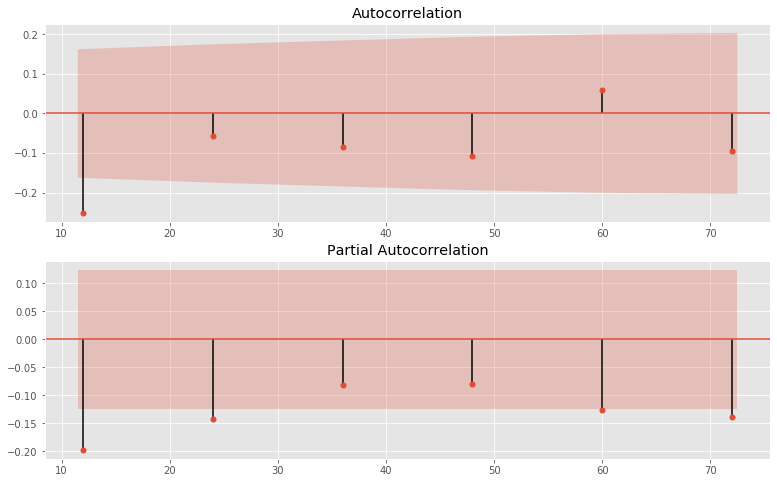

In [349]:
seasonal_plots(TS_33702diff, N=13)

In [350]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_33702diff,information_criterion='aic',m=12,d=1,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=-2237.548, BIC=-2209.002, Fit time=0.470 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2124.618, BIC=-2117.481, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-2132.275, BIC=-2118.001, Fit time=0.261 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-2214.719, BIC=-2200.445, Fit time=0.482 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2126.608, BIC=-2123.039, Fit time=0.031 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=-2241.017, BIC=-2216.038, Fit time=0.508 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=-2232.828, BIC=-2211.418, Fit time=0.354 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 12); AIC=-2263.022, BIC=-2234.475, Fit time=1.698 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=-2258.315, BIC=-2226.199, Fit time=0.886 seconds
Fit ARIMA:

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

                                 Statespace Model Results                                 
Dep. Variable:                                ret   No. Observations:                  227
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 12)   Log Likelihood                 997.440
Date:                            Thu, 23 Jan 2020   AIC                          -1984.881
Time:                                    12:57:23   BIC                          -1967.778
Sample:                                06-01-1996   HQIC                         -1977.979
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5381      0.048    -11.153      0.000      -0.633      -0.444
ma.L2         -0.3921      0.045   

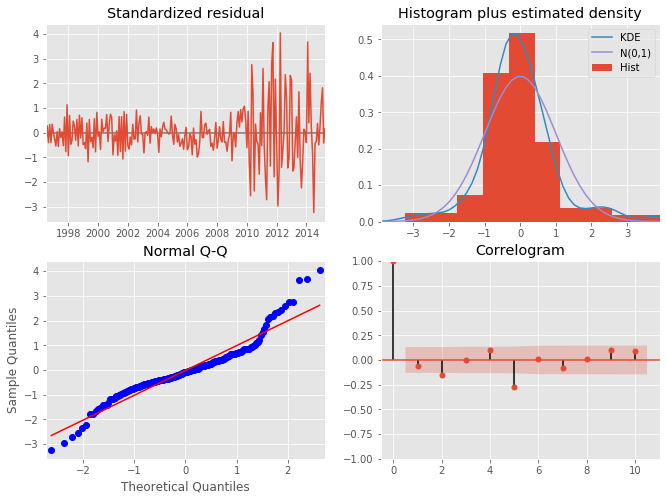

In [351]:
#Fit the SARIMA model and get results.
pdq = (0,1,2)
pdqs = (0,0,2,12)
train, test, results = model_fit(TS_33702diff,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00405


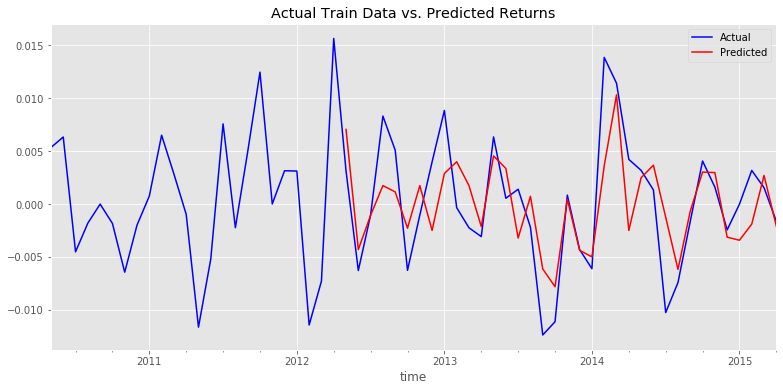

In [352]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00299


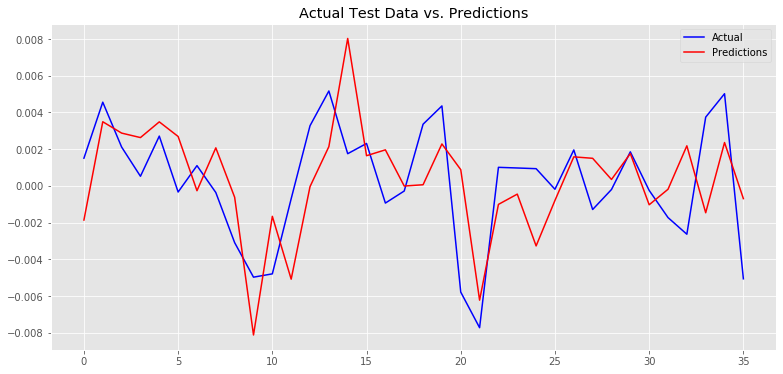

In [353]:
test_RMSE(TS_33702diff,pdq=pdq,pdqs=pdqs, display=True)

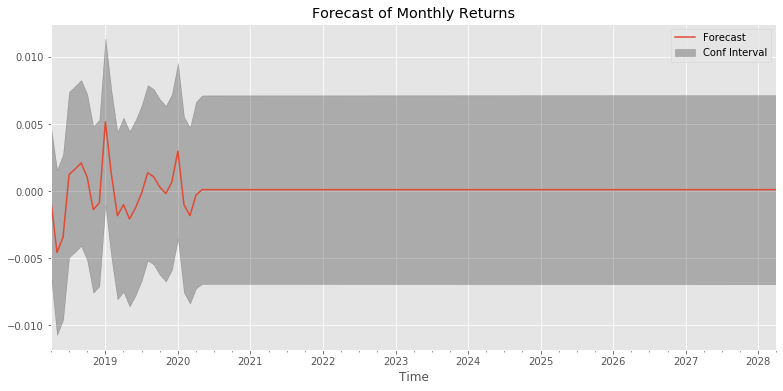

Total expected return in 1 year: -0.05%
Total expected return in 3 years: -0.08%
Total expected return in 5 year: 0.18%
Total expected return in 10 years: 0.82%


In [354]:
forecast_33702 = forecast_model(TS_33702diff,pdq=pdq,pdqs=pdqs,zc=33702)

### 29461 Moncks Corner, SC

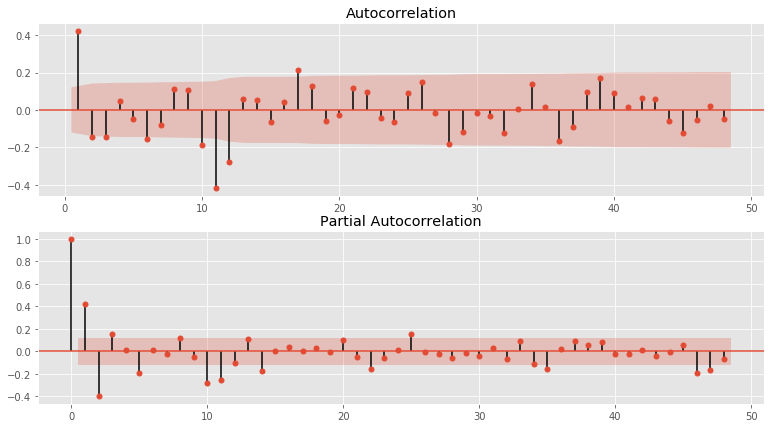

In [363]:
acf_pacf(TS_29461diff)

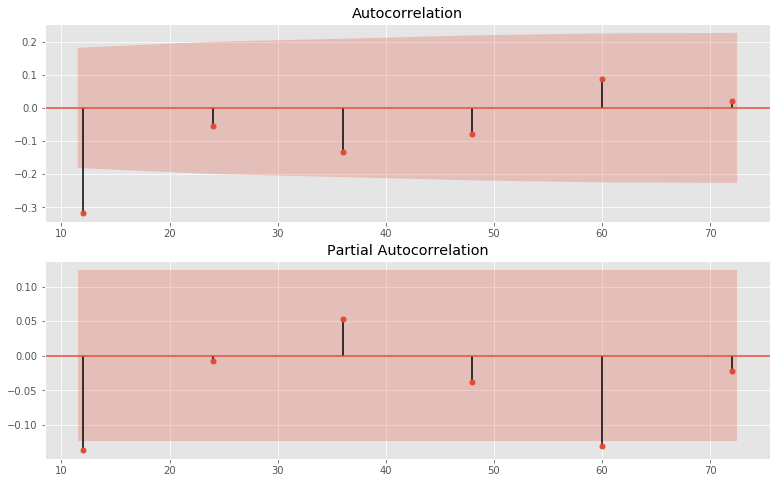

In [364]:
seasonal_plots(TS_29461diff, N=13)

In [370]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_29461,information_criterion='aic',d=1,
                        #start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-2504.152, BIC=-2482.719, Fit time=0.221 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-2404.258, BIC=-2397.113, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-2453.876, BIC=-2443.160, Fit time=0.250 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-2484.166, BIC=-2473.450, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-2406.220, BIC=-2402.647, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-2474.323, BIC=-2456.462, Fit time=0.290 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-2497.516, BIC=-2479.655, Fit time=0.111 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-2488.060, BIC=-2463.055, Fit time=0.483 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-2502.454, BIC=-2477.448, Fit time=0.398 seconds
Fit ARIMA: order=(1

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  227
Model:               SARIMAX(0, 1, 3)   Log Likelihood                1012.075
Date:                Fri, 24 Jan 2020   AIC                          -2016.151
Time:                        08:43:51   BIC                          -2002.469
Sample:                    06-01-1996   HQIC                         -2010.629
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1      -7.108e-08      0.048  -1.48e-06      1.000      -0.094       0.094
ma.L2      -7.759e-06      0.054     -0.000      1.000      -0.106       0.106
ma.L3      -2.996e-06      0.052  -5.81e-05      1.0

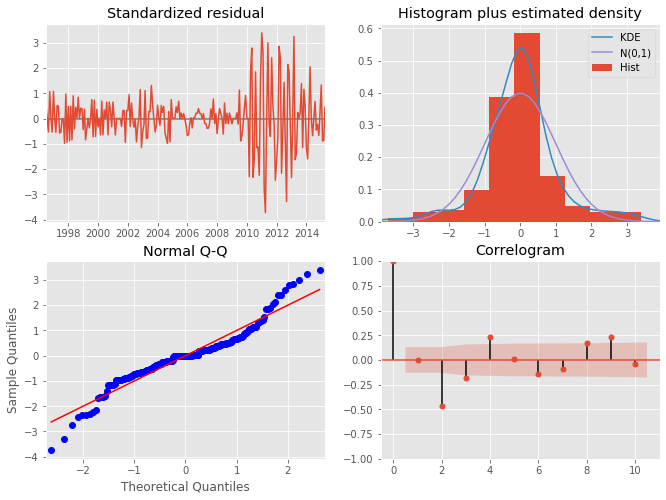

In [371]:
#Fit the SARIMA model and get results.
pdq = (0,1,3)
pdqs = (0,0,0,1)
train, test, results = model_fit(TS_29461diff,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00371


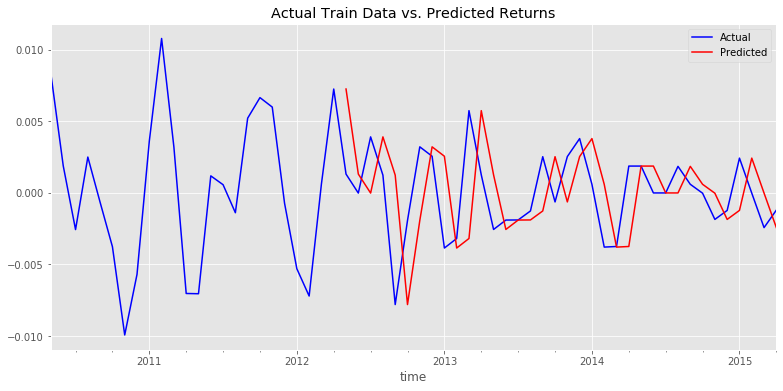

In [372]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00137


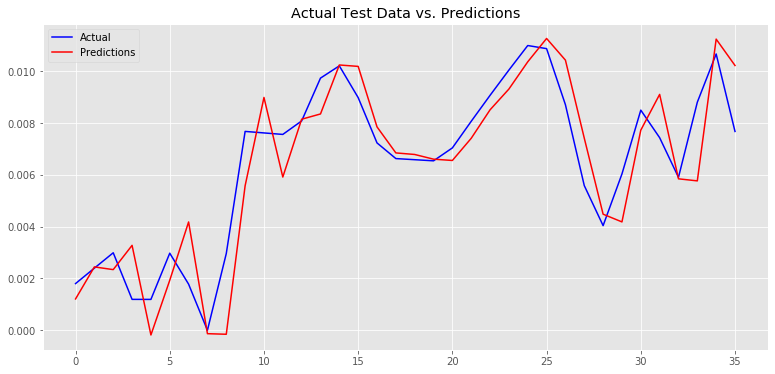

In [373]:
test_RMSE(TS_29461,pdq=pdq,pdqs=pdqs, display=True)

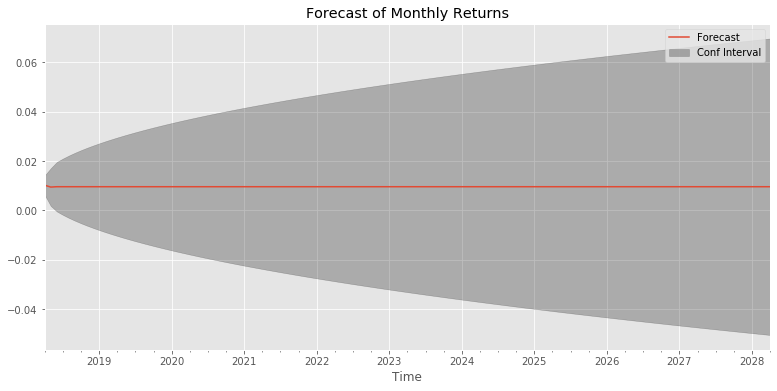

Total expected return in 1 year: 12.19%
Total expected return in 3 years: 41.09%
Total expected return in 5 year: 77.44%
Total expected return in 10 years: 217.71%


In [374]:
forecast_29461 = forecast_model(TS_29461,pdq=pdq,pdqs=pdqs,zc=29461)

### 34698 Dunedin, FL

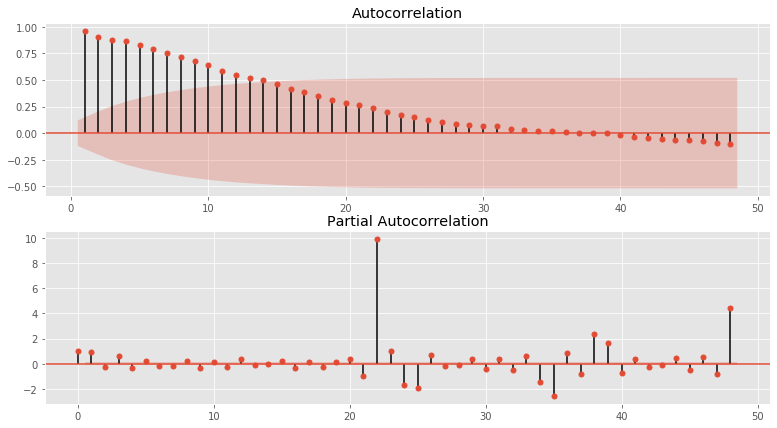

In [424]:
acf_pacf(TS_34698)

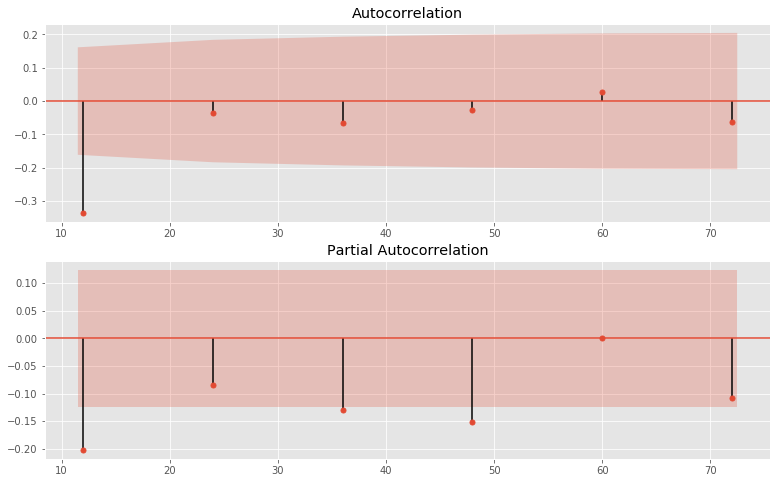

In [425]:
seasonal_plots(TS_34698diff, N=13)

In [431]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_34698,information_criterion='aic',m=12, d=1,
                        #start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=-2453.667, BIC=-2425.090, Fit time=0.428 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2356.818, BIC=-2349.674, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-2389.392, BIC=-2375.104, Fit time=0.429 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-2429.520, BIC=-2415.232, Fit time=0.501 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-2358.680, BIC=-2355.108, Fit time=0.023 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=-2463.136, BIC=-2438.131, Fit time=0.714 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=-2456.040, BIC=-2434.607, Fit time=0.412 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 12); AIC=-2464.585, BIC=-2436.008, Fit time=3.320 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=-2457.295, BIC=-2425.146, Fit time=1.637 seconds
Fit ARIMA:

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

                                 Statespace Model Results                                 
Dep. Variable:                                ret   No. Observations:                  228
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 12)   Log Likelihood                1076.344
Date:                            Fri, 24 Jan 2020   AIC                          -2138.689
Time:                                    11:04:16   BIC                          -2114.714
Sample:                                05-01-1996   HQIC                         -2129.015
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0979      0.146     -0.672      0.502      -0.383       0.188
ar.L2         -0.5488      0.083   

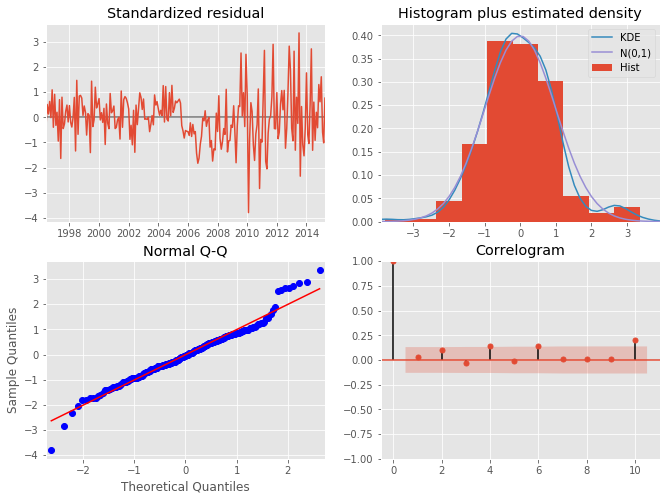

In [432]:
#Fit the SARIMA model and get results.
pdq = (2,1,2)
pdqs = (0,0,2,12)
train, test, results = model_fit(TS_34698,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00284


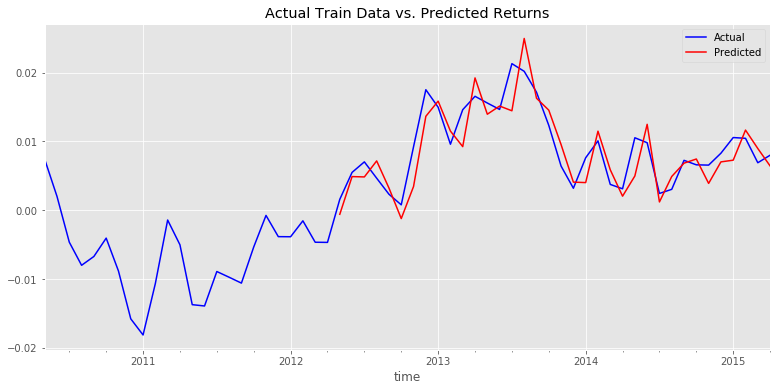

In [433]:
train_RMSE(train, results)

In [437]:
test_RMSE(TS_34698,pdq=pdq,pdqs=pdqs, display=True)

LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 1

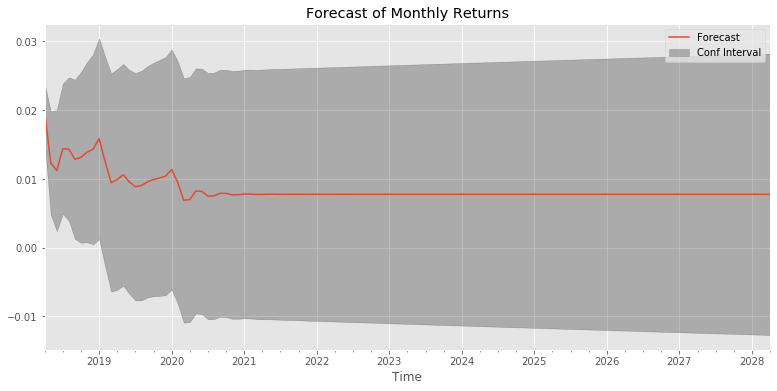

Total expected return in 1 year: 17.69%
Total expected return in 3 years: 44.91%
Total expected return in 5 year: 74.49%
Total expected return in 10 years: 179.8%


In [435]:
forecast_34698 = forecast_model(TS_34698,pdq=pdq,pdqs=pdqs,zc=34698)

# Step 4: Findings and Reccomendations

In [438]:
#Get returns into a data frame and order them in descending order.
tot_returns = [forecast_85281,forecast_33710,forecast_33702,forecast_29461,forecast_34698]
tot_returns = pd.DataFrame(tot_returns,columns=['Zip_code','1-year','3-year','5-year','10-year'])
tot_returns.sort_values('10-year',ascending=False)

,Zip_code,1-year,3-year,5-year,10-year
3,29461,0.121941,0.410933,0.774363,2.177093
4,34698,0.176950,0.449096,0.744923,1.797956
0,85281,0.101333,0.181031,0.198891,0.203718
1,33710,-0.002710,0.005313,0.012212,0.029958
2,33702,-0.000483,-0.000771,0.001765,0.008239


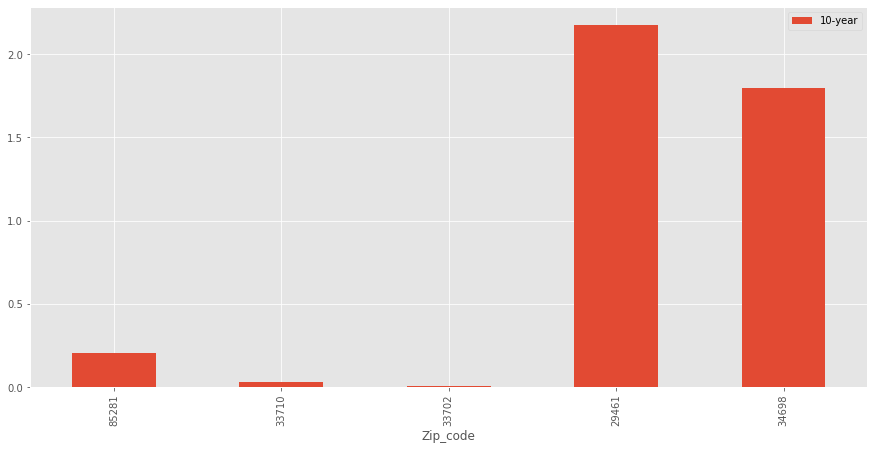

In [439]:
#for i in range(5):
#    tot_returns[i].plot(label=tot_returns[i],figsize=(15,7))
#    plt.legend()
tot_returns.plot(kind='bar',x='Zip_code', y='10-year', figsize=(15,7))
#tot_returns.set_ylabel("10yr Returns")
plt.legend()

According to my analysis, the only zip code that presents a viable investment would be:

* 29461 Moncks Corner, SC
    * Expected gross return of 218% on initial investment after 10 years
     * Historical average was 206%

* 34698 Dunedin, FL
    * 180% gross expected return on initial investment after 10 years
     * 205% Historical ROI from data

# Potential Improvements

#### Additional Factors Outside Median Home Price
    -Size of houses in the study (by bedroom / bathroom or Sq. Ft.) Having more data on median price by square foot, or by bed/bath might be more telling.
    -Strictly larger plot size data for complex structures. Assuming we will be building several townhomes, or an apartment complex, data on only larger plot sizes would be most applicable.
    
#### More Involved Original Reduction than Historic ROI
    Control for economic trends. Take a look at eliminating the housing bubble from the model.
    Rent prices data. We are building property to be rented. Therefore home sale is applicable for the value of the principal, but when considering nett profits, we would want rent data most influencially.
    
#### Potential Policy Changes
      State or Local policies recently enacted effecting zonal rules, retiree incentives, taxes, or legislative by-laws. Any factors that could effect demand or total cost of rent and ownership in each region.
      
#### Sociological Data on Retirement Trends
    More data on retirement movement trends to better predict demand. With more socialogical data we can better predict the most in-demand areas.

### Resources

Coefficient of Variation (COV):
https://www.investopedia.com/ask/answers/031715/what-can-coefficient-variation-cov-tell-investors-about-investments-volatility.asp

General Information on SARIMA Models for Time Series:
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

Out-of-sample forecasts:
https://machinelearningmastery.com/make-sample-forecasts-arima-python/

Time series modelling and forecasting:
https://ilonabrodovska.wordpress.com/2017/06/05/creating-a-time-series-forecast-python-3-step-by-step-guide/

Estimating AR (p) and MA(q) parameters using ACF and PACF plots:
https://stats.stackexchange.com/questions/241914/terms-cut-off-and-tail-off-about-acf-pacf-functions

SARIMA Model with Zillow Dataset:
https://medium.com/@feraguilari/time-series-analysis-modfinalproyect-b9fb23c28309?sk=d8a94d92e22647473cf6c1bf3b48720e

Retirement Populations Research:
https://www.investopedia.com/articles/retirement/020117/most-popular-states-retire-us.asp